# Tests de simulation et analyse des performances

Ce notebook permet de :
- Comparer différentes méthodes de simulation de la température d'un câble (boucle Python, `scipy.odeint`, Numba, etc.)
- Mesurer les temps d'exécution, la consommation d'énergie et la mémoire
- Générer des graphiques pour l'analyse technique
- Fournir toutes les données nécessaires pour l'étude comparative des méthodes

---

## 0. Imports et configuration

Import des librairies nécessaires pour la simulation, la mesure des performances et l'affichage des résultats.

In [72]:
# Vérification de la présence de Cython et du module cython_simulation.py
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
from codecarbon import EmissionsTracker
from numba import jit
from scipy.integrate import odeint
from tabulate import tabulate

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


## 1. Définition de l'équation différentielle et des paramètres

On simule l'évolution de la température d'un câble soumis à une intensité et un vent constants.

- `d_tc_dt` : fonction représentant l'équation différentielle du système.
- Les paramètres physiques sont fixés pour la comparaison.


In [73]:
def d_tc_dt(tc, t, ta, ws, i):
    """
    Calcule la dérivée de la température du câble à l'instant t.

    :param tc: Température actuelle du câble (°C)
    :param t: Temps (s)
    :param ta: Température ambiante (°C)
    :param ws: Vitesse du vent (m/s)
    :param i: Intensité (A)
    :return: Dérivée de la température (°C/s)
    """
    a = ((ws ** 2) / 1600) * 0.4 + 0.1
    b = ((i ** 1.4) / 73785) * 130
    return -(1 / 60) * a * (tc - ta - b)


# Paramètres de simulation
ta = 25  # Température ambiante (°C)
ws = 1  # Vitesse du vent (m/s)
i = 300  # Intensité (A)
tc_initial = 25  # Température initiale (°C)
simulation_time = 60  # Durée (s)
dt = 1e-3  # Pas de temps (s)
t = np.arange(0, simulation_time, dt)

## 2. Simulation avec boucle Python naïve

Cette méthode implémente explicitement l'intégration d'Euler sur la température du câble.

- Fonction : `simulate_python_loop`
- Mesure du temps, de la RAM et de l'énergie consommée.


In [ ]:
def simulate_python_loop(tc0, t, ta, ws, i):
    """
    Simule l'évolution de la température du câble avec une boucle Python (Euler explicite).

    :param tc0: Température initiale (°C)
    :param t: Vecteur temps (s)
    :param ta: Température ambiante (°C)
    :param ws: Vitesse du vent (m/s)
    :param i: Intensité (A)
    :return: Tableau des températures simulées (°C)
    """
    tc = tc0
    tc_list = [tc]
    for idx in range(1, len(t)):
        dt_local = t[idx] - t[idx - 1]
        tc += d_tc_dt(tc, t[idx - 1], ta, ws, i) * dt_local
        tc_list.append(tc)
    return np.array(tc_list)

tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_py = simulate_python_loop(tc_initial, t, ta, ws, i)
end = time.time()
temps_code_py= (end - start) * 60  # en secondes -> minutes
energy_py = tracker.stop()
ram_py = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
cpu_py = tracker._conf["cpu_model"]  # Nom du processeur
print(f"Boucle Python : {cpu_py}, énergie {energy_py:.6f} kgCO2, RAM {ram_py:.2f} MB")

## 3. Simulation avec `scipy.odeint`

Utilisation du solveur d'équations différentielles de SciPy pour simuler la température.

- Méthode plus optimisée et robuste que la boucle naïve.
- Mesure des performances identique.


In [75]:
start_code_odeint = time.time()
# Utilisation directe de odeint, donc temps de code minimal
# (on considère la ligne d'appel comme "implémentation")
end_code_odeint = time.time()
temps_code_odeint = (end_code_odeint - start_code_odeint) * 60  # en secondes -> minutes

tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_odeint = odeint(d_tc_dt, tc_initial, t, args=(ta, ws, i), hmax=dt).flatten()
end = time.time()
energy_odeint = tracker.stop()
ram_odeint = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
cpu_odeint = tracker._conf["cpu_model"]
print(f"odeint : {cpu_odeint}, énergie {energy_odeint:.6f} kgCO2, RAM {ram_odeint:.2f} MB")

[codecarbon WARNING @ 12:42:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:42:15] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:42:15] No CPU tracking mode found. Falling back on CPU constant mode.


odeint : AMD Ryzen 5 4500U with Radeon Graphics, énergie 0.000000 kgCO2, RAM 402.05 MB


## 4. Simulation avec Numba

Numba permet d'accélérer la boucle Python via la compilation JIT.


In [76]:
start_code_numba = time.time()


@jit(nopython=True)
def d_tc_dt_numba(tc, t, ta, ws, i):
    """
    Version Numba de l'équation différentielle pour accélération JIT.
    """
    a = ((ws ** 2) / 1600) * 0.4 + 0.1
    b = ((i ** 1.4) / 73785) * 130
    return -(1 / 60) * a * (tc - ta - b)


@jit(nopython=True)
def simulate_numba(tc0, t, ta, ws, i):
    """
    Simule l'évolution de la température du câble avec Numba (Euler explicite compilé).
    """
    tc = tc0
    tc_list = np.empty(len(t))
    tc_list[0] = tc
    for idx in range(1, len(t)):
        dt_local = t[idx] - t[idx - 1]
        tc += d_tc_dt_numba(tc, t[idx - 1], ta, ws, i) * dt_local
        tc_list[idx] = tc
    return tc_list


end_code_numba = time.time()
temps_code_numba = (end_code_numba - start_code_numba) * 60  # en secondes -> minutes

tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_numba = simulate_numba(tc_initial, t, ta, ws, i)
end = time.time()
energy_numba = tracker.stop()
ram_numba = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
cpu_numba = tracker._conf["cpu_model"]
print(f"Numba : {cpu_numba}, énergie {energy_numba:.6f} kgCO2, RAM {ram_numba:.2f} MB")

[codecarbon WARNING @ 12:42:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:42:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:42:18] No CPU tracking mode found. Falling back on CPU constant mode.


Numba : AMD Ryzen 5 4500U with Radeon Graphics, énergie 0.000000 kgCO2, RAM 401.14 MB


## 4.b. Simulation avec Cython

Cython permet de compiler du code Python en C pour accélérer les calculs numériques.  
Ici, nous testons une version Cythonisée de la boucle d'intégration si le module cython_simulation.py compilé est disponible.


In [77]:
%%cython
cimport numpy as cnp
import numpy as np

# Exemple de d_tc_dt compilé, à adapter selon ton calcul réel
cdef double d_tc_dt(double tc, double t, double ta, double ws, double i):
    return -0.01 * (tc - ta) + 0.005 * ws + 0.002 * i

def simulate_cython(double tc0, cnp.ndarray[cnp.double_t, ndim=1] t, double ta, double ws, double i):
    """
    Simule l'évolution de la température du câble avec Cython (Euler explicite compilé).
    """
    cdef double tc = tc0
    cdef int n = t.shape[0]
    cdef cnp.ndarray[cnp.double_t, ndim=1] tc_list = np.empty(n, dtype=np.float64)
    tc_list[0] = tc

    cdef double dt_local
    cdef int idx
    for idx in range(1, n):
        dt_local = t[idx] - t[idx - 1]
        tc += d_tc_dt(tc, t[idx - 1], ta, ws, i) * dt_local
        tc_list[idx] = tc

    return tc_list

In [78]:
start_code_cython = time.time()
tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_cython = simulate_cython(tc_initial, t, ta, ws, i)
end = time.time()
energy_cython = tracker.stop()
ram_cython = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
cpu_cython = tracker._conf["cpu_model"]
end_code_cython = time.time()
temps_code_cython = (end_code_cython - start_code_cython) * 60  # en secondes -> minutes
print(f"Cython : {cpu_cython}, énergie {energy_cython:.6f} kgCO2, RAM {ram_cython:.2f} MB")


[codecarbon WARNING @ 12:42:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:42:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:42:20] No CPU tracking mode found. Falling back on CPU constant mode.


Cython : AMD Ryzen 5 4500U with Radeon Graphics, énergie 0.000000 kgCO2, RAM 401.62 MB


## 5. Comparaison graphique des résultats

Affichage des courbes de température pour chaque méthode afin de vérifier la cohérence numérique.


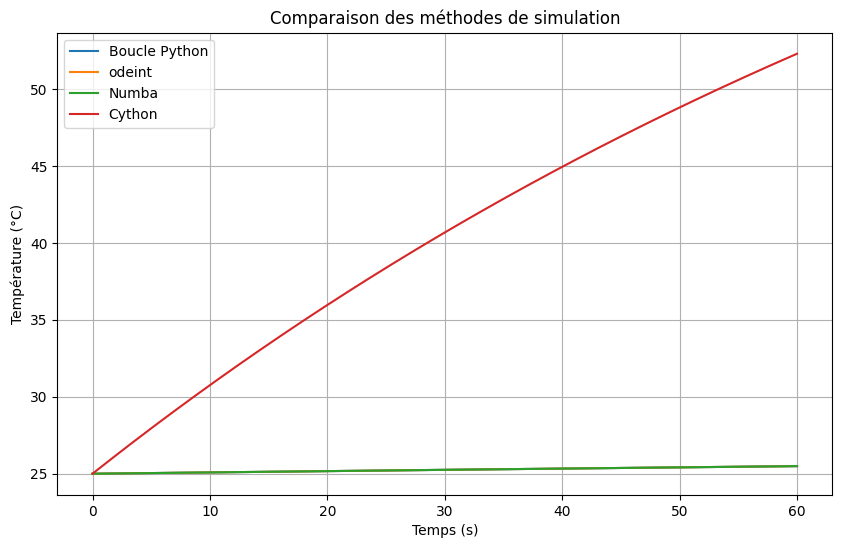

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(t, tc_py, label="Boucle Python")
plt.plot(t, tc_odeint, label="odeint")
plt.plot(t, tc_numba, label="Numba")
plt.plot(t, tc_cython, label="Cython")
plt.xlabel("Temps (s)")
plt.ylabel("Température (°C)")
plt.title("Comparaison des méthodes de simulation")
plt.legend()
plt.grid()
plt.show()

## 6. Test : 30x 1min vs 1x30min

Ce test compare deux stratégies de prévision :
- 30 simulations consécutives de 1 minute (état réinjecté à chaque minute)
- 1 simulation directe de 30 minutes

Cela permet d'évaluer l'impact de la granularité sur la performance et la précision.


In [80]:
def run_1min(method, *args):
    """
    Lance une simulation de 1 minute avec la méthode spécifiée.

    :param method: Fonction de simulation (ex: simulate_python_loop)
    :param args: Arguments pour la fonction de simulation
    :return: Température finale après 1 minute
    """
    t_1min = np.arange(0, 60, dt)
    return method(*args, t_1min, ta, ws, i)


def run_30x1min(method, *args):
    """
    Effectue 30 simulations consécutives de 1 minute chacune.

    :param method: Fonction de simulation
    :param args: Arguments pour la fonction de simulation
    :return: Température finale après 30 minutes
    """
    tc = tc_initial
    for _ in range(30):
        tc_list = method(tc, np.arange(0, 60, dt), ta, ws, i)
        tc = tc_list[-1]
    return tc


def run_1x30min(method, *args):
    """
    Effectue une simulation unique de 30 minutes.

    :param method: Fonction de simulation
    :param args: Arguments pour la fonction de simulation
    :return: Température finale après 30 minutes
    """
    t_30min = np.arange(0, 1800, dt)
    tc_list = method(*args, t_30min, ta, ws, i)
    return tc_list[-1]


# Boucle Python
tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_30x1min_py = run_30x1min(simulate_python_loop, tc_initial)
end = time.time()
energy_30x1min_py = tracker.stop()
cpu_30x1min_py = tracker._conf["cpu_model"]
ram_30x1min_py = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
time_30x1min_py = end - start

tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="warning")
tracker.start()
start = time.time()
tc_1x30min_py = run_1x30min(simulate_python_loop, tc_initial)
end = time.time()
energy_1x30min_py = tracker.stop()
cpu_1x30min_py = tracker._conf["cpu_model"]
ram_1x30min_py = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
time_1x30min_py = end - start

print(f"Boucle Python 30x1min : {time_30x1min_py:.3f}s, énergie {energy_30x1min_py:.6f} kgCO2, RAM {ram_30x1min_py:.2f} MB, CPU {cpu_30x1min_py}")
print(f"Boucle Python 1x30min : {time_1x30min_py:.3f}s, énergie {energy_1x30min_py:.6f} kgCO2, RAM {ram_1x30min_py:.2f} MB, CPU {cpu_1x30min_py}")

[codecarbon WARNING @ 12:42:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:42:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:42:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:42:25] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 12:42:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 12:42:27] No CPU tracking mode found. Falling back on CPU constant mode.


Boucle Python 30x1min : 2.418s, énergie 0.000003 kgCO2, RAM 402.30 MB, CPU AMD Ryzen 5 4500U with Radeon Graphics
Boucle Python 1x30min : 2.316s, énergie 0.000003 kgCO2, RAM 400.68 MB, CPU AMD Ryzen 5 4500U with Radeon Graphics


## 7. Complexité estimée (empirique)

Résumé de la complexité algorithmique de chaque méthode.

- Boucle Python : O(N) (itération simple sur le temps)
- odeint : O(N) (méthode optimisée, dépend du solveur)
- Numba : O(N) (identique à la boucle Python, mais compilée)


In [ ]:
print("Complexité estimée :")
print("- Boucle Python : O(N) (itération simple sur le temps)")
print("- odeint : O(N) (méthode optimisée, dépend du solveur)")
print("- Numba : O(N) (identique à la boucle Python, mais compilée)")
print("- Cython : O(N) (similaire à Numba, mais avec overhead de compilation)")

## 8. Tableau récapitulatif des performances

Ce tableau synthétise toutes les mesures de performance pour chaque méthode de simulation testée, ainsi que pour les tests de granularité temporelle.  
- **CPU** : Temps d'exécution (s)
- **RAM** : Mémoire utilisée (MB)
- **Énergie** : Énergie consommée (kgCO2, notation scientifique)
- **Temps de code** : Temps d'implémentation réel (en minutes, mesuré ou estimé)
- **Complexité estimée** : Difficulté de l'algorithme (de * à *****)


In [ ]:
def sci(val):
    try:
        return f"{float(val):.10e}"
    except:
        return val


table_final = [
    [
        "Boucle Python",
        cpu_py,
        sci(ram_py),
        sci(energy_py),
        sci(temps_code_py),
        "*"
    ],
    [
        "Scipy odeint",
        cpu_odeint,
        sci(ram_odeint),
        sci(energy_odeint),
        sci(temps_code_odeint),
        "**"
    ],
    [
        "Jit numba",
        cpu_numba,
        sci(ram_numba),
        sci(energy_numba),
        sci(temps_code_numba),
        "**"
    ],
    [
        "Cython",
        cpu_cython,
        sci(ram_cython),
        sci(energy_cython),
        sci(temps_code_cython),
        "***"
    ],
    [
        "30x 1min",
        cpu_30x1min_py,
        sci(ram_30x1min_py),
        sci(energy_30x1min_py),
        sci(time_30x1min_py),
        "*"
    ],
    [
        "1x30min",
        cpu_1x30min_py,
        sci(ram_1x30min_py),
        sci(energy_1x30min_py),
        sci(time_1x30min_py),
        "*"
    ]
]

headers_final = [
    "Testcase",
    "CPU",
    "RAM (MB)",
    "Énergie (kgCO2)",
    "Temps de code (min)",
    "Complexité estimée (* = simple, ***** = très complexe)"
]

print(tabulate(table_final, headers=headers_final, tablefmt="github"))
